# Improving Montreal's BIXI Bikeshare System

In [14]:
#used libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json
import folium
from folium import plugins
import re
from haversine import haversine, Unit
from datetime import datetime, date, time
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from collections import namedtuple
import geopandas as gpd
from folium.plugins import HeatMap

### Why Bikeshare?

Bikeshare systems are an alternative form of public transport to traditional buses and subways which allow users to pick up and drop of shared bikes at specific stations around the city. The use of the bikeshare system has been increasing, making it an important feature to consider in the city's complete transport system. In the last year however it has begun to decrease; an improvement of the system may be able to bring usage back up. Biking is both more environmentally friendly and more healthy than automobiles, and incorporating this system is a benefit to the city's inhabitants. we thus want to analyse the system to see how people currenlty use the system and then find improvements to maximize and encourage the use of this beneficial form of transport. We especially want to analyse it with respect to it's interactions and incorportation with other tranport infrastructures. 

In [15]:
#load the bixi data
data = pd.read_pickle("../combined_new_stations")
stations = pd.read_pickle("../stations")

In [16]:
#total number of trips
trips = data.groupby('year').sum()
plt.plot(trips.index, trips.counts)
plt.ylabel('Total Number of Trips')
plt.xlabel('Year')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'counts'

### Research Questions
1. Do the trips taken align with existing public transport lines or are they used to fill the gaps of the public transport routes?
2. Are some areas of Montreal more bike-friendly than others (i.e. have bike lanes or are smaller roads) and is this bike friendliness correlated with more trips done in that area?

# Datasets
To complete our analysis we worked with several different datasets:
1. BIXI Bikeshare trips (type = .csv, files = data for each year and month, station locations and codes for each year)
2. Montreal weather data (type = .csv, files = ...... )
3. Public transport schedule (type = , files = )
4. Bike paths (type = .geojson, files = )

Each of these datasets was treated in a different way in order to compile everything into a format where the data could be compared

### Bikeshare dataset

The first task was to combine the separate files for each year and month into a single dataframe. The station data (coordinates) was also merged and the dates converted to datetime and separated by year, month, day and hour for ease of analysis later. Additionally the 'distance' (more accurately displacement) of each trip was calculated using the haversine function (this is the straight line between the start and end station and does not reflect the actual distance traveled by the bike). 

The data was very clean already, with no NaNs, consistent formatting, and a reasonable looking distribution. We will focus on the data from 2019 for our analysis since public transport schedules and infrastructure, as well as the bike share infrastructure change each year, so in order to compare we need to look at a single year. For example the BIXI stations with the same code can change locations each year. The bus schedule also differs and bike lanes are added/demolished.

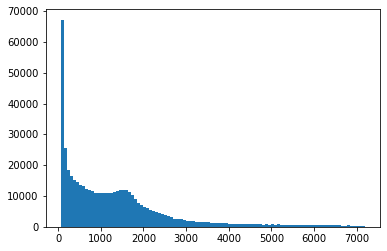

In [17]:
#round trip distribution
data_og = pd.read_pickle("../combined_data_old")
return_trip = data_og[data_og['distance']==0.0]
plt.hist(return_trip['duration_sec'], bins=100)
plt.show()

The above plot illustrates the distribution of return trips (start and end stations are the same). There is a disproportionately high number of trips which return to the same station at a very small duration. This is likely from broken bikes which are signed out but then returned very quickly to the same station. We thus decided to remove these data points, elminating any trips which returned to the same station and have a duration of less than 3 minutes. 

In [18]:
#2019 data only
data19 = pd.read_pickle("../combined2019")
data.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,latitude_start,longitude_start,latitude_end,longitude_end,year,month,start_day,start_hour,end_day,end_hour
0,2014-04-15 00:01:00,6209,2014-04-15 00:18:00,6436,1061,1,45.512541,-73.570677,45.485801,-73.595797,2014,4,15,0,15,0
1,2014-04-15 00:01:00,6214,2014-04-15 00:11:00,6248,615,1,45.516091,-73.570129,45.518593,-73.581566,2014,4,15,0,15,0
2,2014-04-15 00:01:00,6164,2014-04-15 00:18:00,6216,1031,1,45.533314,-73.583737,45.514840,-73.584779,2014,4,15,0,15,0
3,2014-04-15 00:01:00,6214,2014-04-15 00:24:00,6082,1382,1,45.516091,-73.570129,45.549900,-73.583084,2014,4,15,0,15,0
4,2014-04-15 00:02:00,6149,2014-04-15 00:08:00,6265,347,1,45.538670,-73.569360,45.539259,-73.577459,2014,4,15,0,15,0


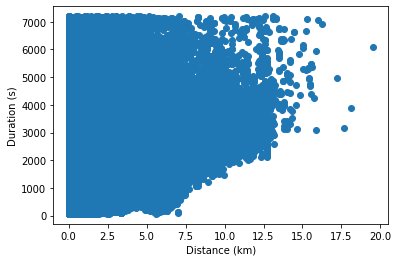

In [19]:
#raw data plot
plt.scatter(data19.distance, data19.duration_sec)
plt.ylabel('Duration (s)')
plt.xlabel('Distance (km)')
plt.show()

As expected the bottom right corner of the plot has no data points since there is a limit to how fast bikers can travel between two stations. 

# BIXI Bikeshare System

We first wanted to get a general idea of how the system was being used and what kind of trips were taken on it. We also looked at the setup, including distribution of stations across the city. 

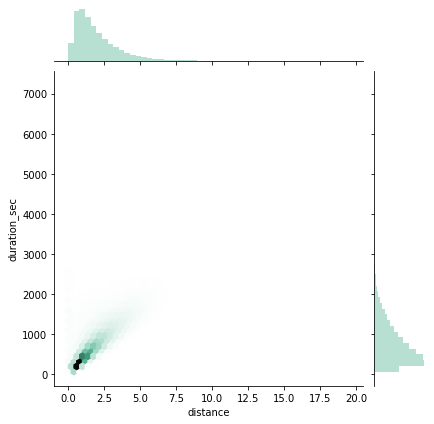

In [20]:
#distance vs duration for 2019 (all months)
sns.jointplot(data19.distance, data19.duration_sec, kind='hex', color="#4CB391")
plt.show()

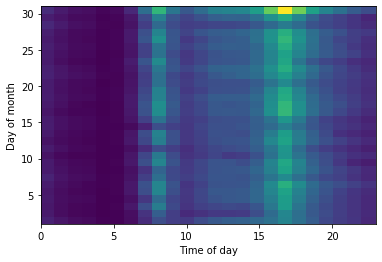

In [21]:
#time of day of usage (start of usage) vs days of the year (with overall histograms on the side)
plt.hist2d(data19.start_hour, data19.start_day, bins=[24,30])
plt.xlabel('Time of day')
plt.ylabel('Day of month')
plt.show()

We can see the system is mostly used for short distance trips indicating use for commuting. We see a linear relationship between distance and duration indicating most people take around the same time to bike from one station to the next and not many are completing touring rides (which would appear as a relatively long duration for a short distance). In addition the increased use around the hours that people go to and get off work supports this conclusion.

### Which stations are the most popular?

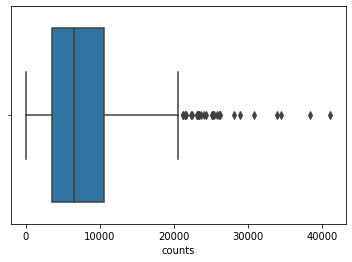

In [22]:
#station use count (by number of rides starting from that station)
station_use = data19.groupby(['start_station_code']).size().reset_index(name='counts')
use_dur = data19[['start_station_code','duration_sec']].groupby(['start_station_code']).mean().reset_index()
station_use['duration'] = use_dur['duration_sec']

station_use = station_use.merge(stations[['latitude','longitude']], how='left', left_on=['start_station_code'], right_on=['code'])
sns.boxplot(x=station_use['counts'])

In [23]:
#location of montreal
montreal = [45.5017, -73.5673]

#station popularity as a heatmap
hm = folium.Map(location=montreal, tiles='Stamen Toner', zoom_start=14)
HeatMap(data=station_use[['latitude', 'longitude', 'counts']], radius=8, max_zoom=13).add_to(hm)
hm

We can see that most trips are started downtown around the old town. 

### Which routes are the most popular?

Now instead of looking at where people start their rides, we want to look at the actual paths that are most common. This is the format we want our data in to compare to bike lane density and public transport lines. For this we create a 'paths' dataframe:

In [24]:
#create dataframe with the paths taken and the frequency as well as duration
data_sub = data19[['start_station_code','end_station_code','latitude_start','longitude_start','latitude_end','longitude_end','distance']]
paths = data19.groupby(['start_station_code','end_station_code']).size().reset_index(name='counts')
paths_dur = data19[['start_station_code','end_station_code','duration_sec']].groupby(['start_station_code','end_station_code']).mean().reset_index()
paths['duration'] = paths_dur['duration_sec']
paths = paths.merge(data_sub.drop_duplicates(), how='left', on=['start_station_code','end_station_code'])
paths.head()

,start_station_code,end_station_code,counts,duration,latitude_start,longitude_start,latitude_end,longitude_end,distance
0,4000,4000,103,1173.126214,45.549598,-73.541874,45.549598,-73.541874,0.000000
1,4000,4002,1,1864.000000,45.549598,-73.541874,45.516937,-73.640483,8.496129
2,4000,5007,1,3585.000000,45.549598,-73.541874,45.523319,-73.520127,3.377533
3,4000,6001,53,1411.509434,45.549598,-73.541874,45.510351,-73.556508,4.510499
4,4000,6002,95,504.852632,45.549598,-73.541874,45.539385,-73.541000,1.137631


We can also visualize the most frequent routes taken:

In [25]:
def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

def get_arrows(locations, color='black', size=6, n_arrows=3):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill=True, fill_color=color, color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))
    return arrows

In [26]:
#create a map with the
m = folium.Map(location=montreal, tiles='Stamen Terrain', zoom_start=13)
station_pop = station_use.query('counts>15000')
for lat, lng, name, count in zip(station_pop.latitude, station_pop.longitude, station_pop.start_station_code, station_pop.counts):
    m.add_child(folium.CircleMarker(location=[lat,lng], fill='true', radius=count/10000, popup=name, fill_color='red', color='red'))

vis = paths.query('counts>1200')

#plot lines between the stations according to number of trips taken
for index, row in vis.iterrows():
    folium.PolyLine([[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], color="green", weight=row['counts']/500).add_to(m) 
    arrows = get_arrows(locations=[[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], n_arrows=1)
    for arrow in arrows:
        arrow.add_to(m)
    
#put marker for end stations that are not one of the popular start stations    
filt = vis[~vis['end_station_code'].isin(station_pop['start_station_code'])]
for lat, lng, name in zip(filt.latitude_end,filt.longitude_end,filt.end_station_code):
    m.add_child(folium.CircleMarker(location=[lat,lng], fill=True, radius=2, popup=name, fill_color='blue', color='blue'))
    
m

- Red dots are one of the most popular stations to start from
- Lines are the most popular routes to take
- Blue dotes are end points which are not one of the most popular stations


# Correlation with Weather

# Integration with Buses and Metros

# Bike friendly roads increase bike use?